In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [6]:
# データタイプを指定
types_dict_train = {'train_id':'int64', 'item_condition_id':'int8', 'price':'float64', 'shipping':'int8'}
types_dict_test = {'test_id':'int64', 'item_condition_id':'int8', 'shipping':'int8'}
 
# tsvファイルからPandas DataFrameへ読み込み
train_df = pd.read_csv('./data/train.tsv', sep='\t', low_memory=True, dtype=types_dict_train)
test_df = pd.read_csv('./data/test.tsv', sep='\t', low_memory=True, dtype=types_dict_test)

In [9]:
train_df.shape, test_df.shape

((1482535, 8), (693359, 7))

In [11]:
len(train_df) - train_df.count()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [12]:
len(test_df) - test_df.count()

test_id                   0
name                      0
item_condition_id         0
category_name          3058
brand_name           295525
shipping                  0
item_description          0
dtype: int64

- brand_nameの欠損結構多い

# データの情報

https://www.codexa.net/kaggle-mercari-price-suggestion-challenge/


- train_id / test _id – ユーザー投稿のID
- name – 投稿のタイトル。タイトルに価格に関する情報がある場合（例：$20）はメルカリが事前に削除をして[rm]と置き換えています。
- item_condition_id – ユーザーが指定した商品の状態
    - 1 ~ 5っぽいけど、それぞれが何を意味しているかわからない
- category_name – 投稿カテゴリー
- brand_name – ブランドの名前
- price – 訓練データのみ。実際に売られた価格。米ドル表示。今回のチャレンジの予測ターゲットとなります。
- shipping – 送料のフラグ。「1」は販売者負担。「0」は購入者負担。
- item_description – ユーザーが投稿した商品説明の全文。タイトルと同様に価格情報がある場合は[rm]と置き換えられています。

In [20]:
pd.options.display.float_format = '{:.3f}'.format
train_df.describe()

,train_id,item_condition_id,price,shipping
count,1482535.000,1482535.000,1482535.000,1482535.000
mean,741267.000,1.907,26.738,0.447
std,427971.135,0.903,38.586,0.497
min,0.000,1.000,0.000,0.000
25%,370633.500,1.000,10.000,0.000
50%,741267.000,2.000,17.000,0.000
75%,1111900.500,3.000,29.000,1.000
max,1482534.000,5.000,2009.000,1.000


In [21]:
test_df.describe() 

,test_id,item_condition_id,shipping
count,693359.000,693359.000,693359.000
mean,346679.000,1.906,0.448
std,200155.647,0.903,0.497
min,0.000,1.000,0.000
25%,173339.500,1.000,0.000
50%,346679.000,2.000,0.000
75%,520018.500,3.000,1.000
max,693358.000,5.000,1.000


- 訓練のpriceを見ると外れ値が含まれていそう。当てづらいと思うので確認したい

# カテゴリカルなデータを確認する

## name

`タイトルに価格に関する情報がある場合（例：$20）はメルカリが事前に削除をして[rm]と置き換えています。` これは気になる

In [81]:
train_df['name'].sample(n=20, replace=False)

925830       Ultra Glow Highlighter Santorini Kylie
812558                  Grey hooded fabulous shirt.
307635                             Adidas Superstar
1366044                Perfectly poshe fairies mask
759601                                     Crop top
970178                          FS! f21 lace kimono
1043630             NFL Philadelphia Eagles Tshirts
775147                      Mini Makeup Mystery Box
390191     Great northwest button up flannels shirt
187088          Free ship Kat Von d liquid lipstick
395376                 Great for tools or cosmetics
2208           Spice Girls Dolls (6 Total) in Boxes
475526                          Lularoe Patrick tee
598502        Men's shirt/sweatshirt lot size LARGE
1092321                    Rae Dunn coffee canister
1302081                          H&M Black Leggings
1280819         Kylie Cosmetics Liner/Eyebrow Brush
550088                 Tupperware pitcher & cup set
1131303                  Build a beard ginger bread
738594      

In [87]:
train_df[train_df['name'].str.contains('\[rm\]')].name.sample(n=20, replace=False)

1027920         7/[rm] Pilaten blackhead remover masks
1246550      [rm] Sml BOYSHORTS Victoria's Secret PINK
1265875                           BNWT LuLaRoe OS [rm]
1112326                      2 dress bundle [rm] each!
1056016        NEW [rm] Nasty Gal Black Shift Dress XS
317892        TRACTOR PINK SUEDE JACKET [rm] Free-Ship
245547                    *LIKE NEW VS PINK BLING [rm]
811540                                [rm] Yarn - Gray
1287178                                   Similac [rm]
52110      [rm] in Similac formula coupons 2x [rm] off
1017258         (2) For [rm] Mobile grips and car grip
435390                               ⚡️FLASH SALE [rm]
535716               [rm] Orange and Blue Chiffon Tank
1208756                        [rm] Cabela's Gift Card
1138384         COLOURPOP LIPSTICK - BAD HABIT ⭐️ [rm]
1095603        [rm] Lucky Brand Boho Embellished Tunic
986375      [rm] SALE MARY KAY ASST BODY LOTIONS (NEW)
1035748           Cotton Candy Bath Bomb,lip scrub[rm]
23092     

In [90]:
train_df[train_df['name'].str.contains('\[rm\]')].name.count() / train_df.shape[0]

0.0050319216746990796

- タイトルから金額を予想する感覚がわからない
- 絵文字がついてるケースもある。件数はしらない
- タイトルに金額がついてるデータは少ない

## item_condition_id

In [25]:
train_df.groupby(['item_condition_id'])[['item_condition_id']].count()

,item_condition_id
item_condition_id,
1,640549
2,375479
3,432161
4,31962
5,2384


In [27]:
train_df.groupby(['item_condition_id'])[['price']].sum()

,price
item_condition_id,
1,16966200.000
2,10349412.000
3,11469860.000
4,778249.500
5,75582.000


## category_name

In [29]:
train_df['category_name'].head(20)

0                                     Men/Tops/T-shirts
1     Electronics/Computers & Tablets/Components & P...
2                           Women/Tops & Blouses/Blouse
3                    Home/Home Décor/Home Décor Accents
4                               Women/Jewelry/Necklaces
5                                     Women/Other/Other
6                              Women/Swimwear/Two-Piece
7                       Sports & Outdoors/Apparel/Girls
8                       Sports & Outdoors/Apparel/Girls
9              Vintage & Collectibles/Collectibles/Doll
10                                   Beauty/Makeup/Face
11                               Beauty/Fragrance/Women
12                       Women/Dresses/Above Knee, Mini
13                Other/Office supplies/School Supplies
14                                    Women/Shoes/Boots
15                            Beauty/Makeup/Makeup Sets
16                                   Beauty/Makeup/Eyes
17                       Kids/Gear/Backpacks & C

うへえ。なるほど.

見た感じ、 `/` でsplitできそう

In [34]:
category_names = train_df['category_name'].apply(lambda x: str(x).split('/')).tolist()

In [38]:
a, b = np.unique([xx for x in category_names for xx in x], return_counts=True)

In [42]:
category_names_df = pd.DataFrame([a, b], index=['category_name', 'count']).T

In [43]:
category_names_df.head(20)

,category_name,count
0,100 Years or Older,140
1,50 To 75 Years,92
2,75 To 100 Years,42
3,A-Line,756
4,"Above Knee, Mini",20082
5,Accessories,18510
6,Accessory,31
7,Aceo,1
8,Action Figure,5354
9,Action Figures & Statues,12524


In [45]:
category_names_df.sort_values(by=['count'], ascending=False).head(20)

,category_name,count
934,Women,683360
84,Beauty,207828
488,Kids,171796
35,Athletic Apparel,134422
753,Shoes,132620
312,Electronics,126318
541,Makeup,124624
609,Other,115592
860,Tops & Blouses,107967
554,Men,95967


- Womenとかわけわからないけど、webサイトみにいくとどうやら親カテゴリ、小カテゴリがあるっぽいのでsplitするとよくなさそう
- splitの仕方を考える

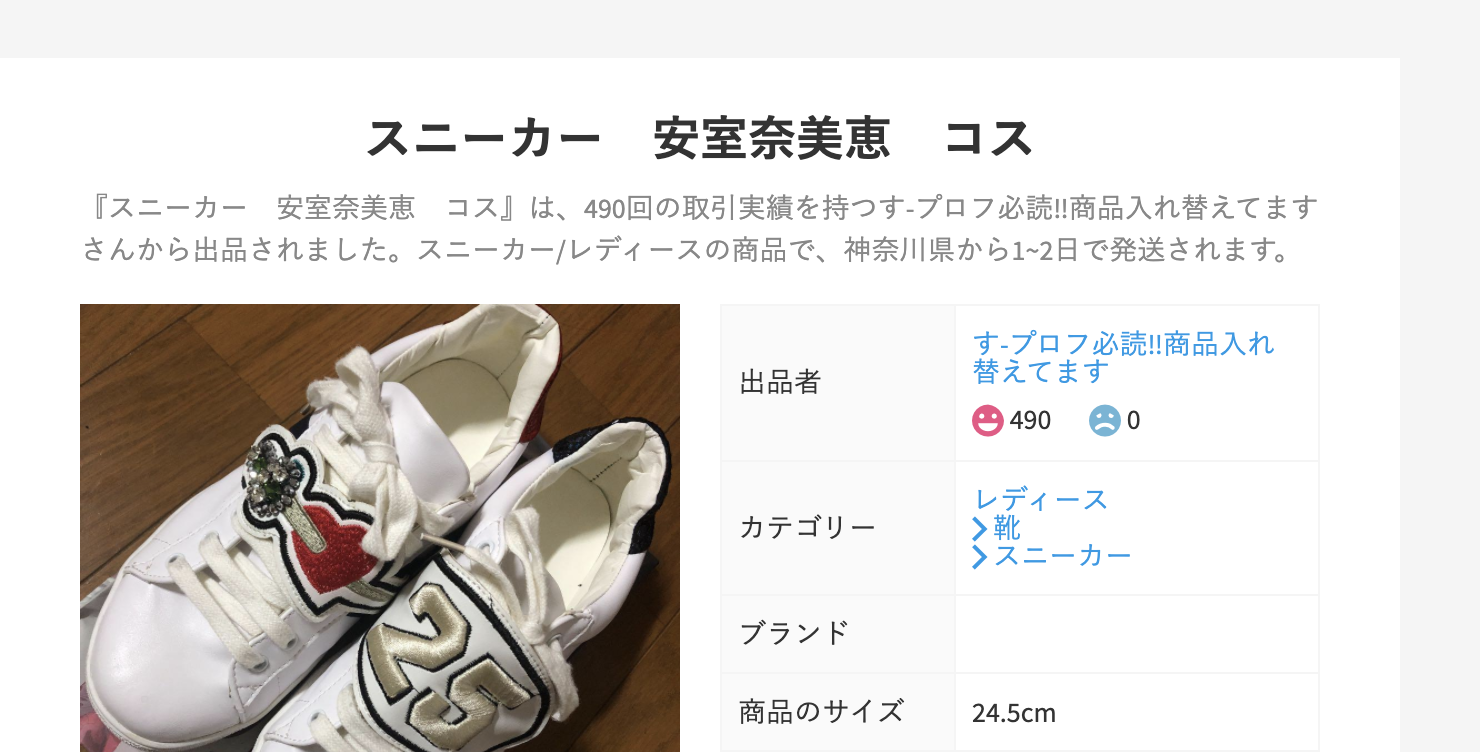

## brand_name

In [58]:
train_df2 = train_df.copy()
train_df2['brand_name'].fillna('nothing', inplace=True)
train_df2.groupby(['brand_name'])[['brand_name']].count().head(20)

,brand_name
brand_name,
!iT Jeans,1
% Pure,61
10.Deep,3
191 Unlimited,1
1byone,1
21men,6
24/7 Comfort Apparel,2
2K Games,1
2XU,2


In [70]:
train_df2.groupby(['brand_name'])[['price']].count().sort_values(by=['price'], ascending=False).head(20)

,price
brand_name,
nothing,632682
PINK,54088
Nike,54043
Victoria's Secret,48036
LuLaRoe,31024
Apple,17322
FOREVER 21,15186
Nintendo,15007
Lululemon,14558


In [61]:
train_df2.groupby(['brand_name'])[['price']].sum().sort_values(by=['price'], ascending=False).head(20)

,price
brand_name,
nothing,13370755.500
Nike,1662377.000
PINK,1424749.000
Apple,1269159.000
Victoria's Secret,1115121.500
LuLaRoe,1044515.000
Michael Kors,867084.500
Lululemon,685634.000
Louis Vuitton,644372.000


In [62]:
train_df2.groupby(['brand_name'])[['price']].sum().sort_values(by=['price'], ascending=True).head(20)

,price
brand_name,
Gossip Girl,0.000
CM Style Fashion,0.000
AA Aquarium,3.000
Play MG,3.000
Ergodyne,3.000
Feetures!,3.000
Ask,3.000
Twilight Gypsy Collective,3.000
DUO,3.000


- ブランド名がついててもうれていない商品がある
- むしろついていないのがトータルめっちゃ多い → まぁでも欠損が `632682` (約42%は欠損)もあるのでしょうがないか的な気持ち

## shipping

In [96]:
train_df.groupby(['shipping'])[['price']].count()

,price
shipping,
0,819435
1,663100


In [97]:
train_df.groupby(['shipping'])[['price']].sum()

,price
shipping,
0,24674644.500
1,14964659.000


## item_description

In [92]:
train_df['item_description'].sample(n=20, replace=False)

1152412    This bundle includes a gameboy color and Pokem...
141716     *CONDITION... *LIKE NEW!!!* very gently preown...
921795     Only worn one time to a wedding. Can be used a...
1101061    Blue/Green Nike Pro shorts - never worn - size...
1079057    NARS Radiant Creamy Concealer 0.04oz Travel Si...
930917     Skinny jeans. Only worn a few times no flaws. ...
935530     Purple and clear fluorite point. This is the l...
125029                       Fits Boy's Ages from around 8-9
208814     New in sealed box!! Instantly glowing and yout...
103956     In perfect gently worn condition. Worn a handf...
706650     Womens North Face polartec jacket size medium,...
1049220    Retail [rm] barely worn super comfy warm and f...
891974                                     Great condition!!
1426834    Rose gold snake skin bodycon dress from Missgu...
456849     The Body Shop satsuma and strawberry body butt...
715251     5 gears of war locust action figure In great c...
165978     The most popu

あとで

# 評価関数
- https://www.kaggle.com/c/mercari-price-suggestion-challenge/overview/evaluation

In [23]:
from sklearn.metrics import mean_squared_log_error

y_true = [100, 110, 120, 130]
y_pred = [110, 120, 130, 140]

rmsle_v = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(rmsle_v)

0.08377189734210047


# ベースラインを確認してみる

- とりあえず無加工でもいける、item_condition_id, shippingで試す

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [103]:
x_columns = ['item_condition_id', 'shipping']
X_train, X_test, y_train, y_test = train_test_split(train_df[x_columns], train_df['price'], test_size=0.3, random_state=71)

In [107]:
lr_model = LinearRegression(normalize=True)
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [110]:
mean_squared_log_error(y_pred=lr_model.predict(X_train), y_true=y_train)

0.6418765771999448

In [111]:
mean_squared_log_error(y_pred=lr_model.predict(X_test), y_true=y_test)

0.6449496317287879

# ランダムシードを変更して試す

In [156]:
for random_state in np.random.randint(1, 100, 10):
    X_train, X_test, y_train, y_test = train_test_split(train_df[x_columns], train_df['price'], test_size=0.3, random_state=random_state)
    lr_model = LinearRegression(normalize=True)
    lr_model.fit(X_train, y_train)
    train_results = mean_squared_log_error(y_pred=lr_model.predict(X_train), y_true=y_train)
    val_results = mean_squared_log_error(y_pred=lr_model.predict(X_test), y_true=y_test)
    print(train_results, val_results)

0.6448870567539697 0.6432778221269406
0.6439106455019332 0.6435159135891272
0.6427308747817311 0.6425159988445677
0.6447629543491205 0.6415006931707563
0.6440194219370201 0.6434128102591667
0.6449015905950203 0.6423367509209452
0.6427893467211999 0.6441994092879874
0.6432007710666495 0.6441935632813575
0.6432378051575378 0.6434333126895166
0.6434369306795019 0.6433759319149106


そんなぶれはないかな

# テストデータで試す

In [116]:
!cat ./data/sample_submission.csv | head

test_id,price
0,26.738
1,26.738
2,26.738
3,26.738
4,26.738
5,26.738
6,26.738
7,26.738
8,26.738
cat: write error: Broken pipe


In [124]:
test_df2 = test_df[['test_id']].copy()

In [125]:
test_df2.loc[:, 'price'] = lr_model.predict(test_df[x_columns])

In [126]:
test_df2.head()

,test_id,price
0,0,23.168
1,1,23.168
2,2,23.168
3,3,30.158
4,4,21.369


In [127]:
from datetime import datetime

In [144]:
a = datetime.now().strftime('%Y%m%d_%H%M%S')
test_df2.to_csv(f'./submission/sub_{a}.csv', index=False)